In [90]:
import pandas as pd
# from fbprophet import Prophet
import pandas
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import numpy as np
from praveganb.pravega_stream import UnindexedStream
import seaborn as sns
import pytz
import grpc
import imp
import pravega.grpc_gateway as pravega
from datetime import datetime, timedelta
%matplotlib inline

# Setup the Connection with pravega and Read System Usage

In [149]:
gateway = '10.243.54.104:80'
scope = 'alerts'
stream = 'snmp-enriched'

In [150]:
pravega_channel = grpc.insecure_channel(gateway, options=[
        ('grpc.max_receive_message_length', 9*1024*1024),
    ])
pravega_client = pravega.grpc.PravegaGatewayStub(pravega_channel)

In [151]:
snmpdata = UnindexedStream(scope='alerts', stream='snmp-enriched', pravega_client=pravega_client)
events = snmpdata.read_events_from_stream(stop_at_tail=True)


In [152]:
df = pd.DataFrame(list(events))

In [153]:
df['timeStrStamp'] = pandas.to_datetime(df['receivedTimestamp'],unit="ms",utc=True)

In [154]:
minTime = (datetime.now() - timedelta(hours = 1)).timestamp() * 1000

In [155]:
df[(df.receivedTimestamp > minTime )]

,securityModel,securityLevel,securityName,peerAddress,peerPort,trap,messageProcessingModel,receivedTimestamp,notifyLevel,notifyMessage,deviceName,deviceMibModule,timeStamp,timeStrStamp
464,2,1,public,100.64.96.231,4292,"{'type': 'TRAP', 'requestId': 373274375, 'erro...",1,1604525772999,5,System.Credentials.MDM_CREDENTIALS_ARE_NOT_CON...,Scale_IO,SCALEIO-MIB,1604526628725,2020-11-04 21:36:12.999000+00:00
465,2,1,public,100.64.96.231,4293,"{'type': 'TRAP', 'requestId': 294497331, 'erro...",1,1604525803000,5,System.Credentials.MDM_CREDENTIALS_ARE_NOT_CON...,Scale_IO,SCALEIO-MIB,1604526628725,2020-11-04 21:36:43+00:00
466,2,1,public,100.64.96.231,4293,"{'type': 'TRAP', 'requestId': 2133175865, 'err...",1,1604525833003,5,System.Credentials.MDM_CREDENTIALS_ARE_NOT_CON...,Scale_IO,SCALEIO-MIB,1604526628725,2020-11-04 21:37:13.003000+00:00
467,2,1,public,100.64.96.231,4294,"{'type': 'TRAP', 'requestId': 1765781356, 'err...",1,1604525863003,5,System.Credentials.MDM_CREDENTIALS_ARE_NOT_CON...,Scale_IO,SCALEIO-MIB,1604526628726,2020-11-04 21:37:43.003000+00:00
468,2,1,public,100.64.96.231,4294,"{'type': 'TRAP', 'requestId': 1572864857, 'err...",1,1604525893003,5,System.Credentials.MDM_CREDENTIALS_ARE_NOT_CON...,Scale_IO,SCALEIO-MIB,1604526628726,2020-11-04 21:38:13.003000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,2,1,public,100.64.96.231,4359,"{'type': 'TRAP', 'requestId': 1227825939, 'err...",1,1604529223098,5,System.Credentials.MDM_CREDENTIALS_ARE_NOT_CON...,Scale_IO,SCALEIO-MIB,1604529223140,2020-11-04 22:33:43.098000+00:00
694,2,1,public,100.64.96.231,4360,"{'type': 'TRAP', 'requestId': 1943368285, 'err...",1,1604529253097,5,System.Credentials.MDM_CREDENTIALS_ARE_NOT_CON...,Scale_IO,SCALEIO-MIB,1604529253195,2020-11-04 22:34:13.097000+00:00
695,2,1,public,100.64.96.231,4360,"{'type': 'TRAP', 'requestId': 865320958, 'erro...",1,1604529283100,5,System.Credentials.MDM_CREDENTIALS_ARE_NOT_CON...,Scale_IO,SCALEIO-MIB,1604529283194,2020-11-04 22:34:43.100000+00:00
696,2,1,public,100.64.96.231,4361,"{'type': 'TRAP', 'requestId': 1952028928, 'err...",1,1604529313101,5,System.Credentials.MDM_CREDENTIALS_ARE_NOT_CON...,Scale_IO,SCALEIO-MIB,1604529313146,2020-11-04 22:35:13.101000+00:00


In [147]:
df.notifyLevel.value_counts()

5    353
0    343
2      1
Name: notifyLevel, dtype: int64

In [148]:
df[['deviceMibModule','notifyLevel', 'notifyMessage']].value_counts()

deviceMibModule  notifyLevel  notifyMessage                                        
SCALEIO-MIB      5            System.Credentials.MDM_CREDENTIALS_ARE_NOT_CONFIGURED    353
ISILON-TRAP-MIB  0            External network problem                                 288
                              SW_TEST_EVENT                                             30
                              SW_MOUNTD_CLIENT_MOUNT_FAILED                             18
                              SW_ESRS_UNCONFIGURED                                       6
SCALEIO-MIB      2            Esrs.Esrs.NOT_REGISTERED                                   1
ECS-MIB          0            Send SNMP Test Trap                                        1
dtype: int64

<AxesSubplot:>

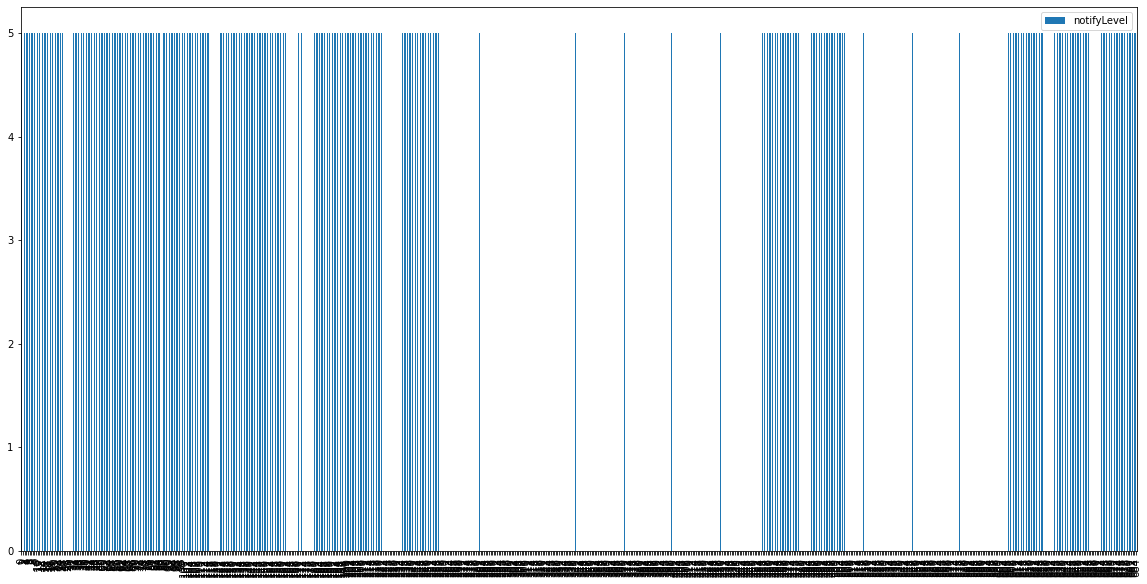

In [114]:
df[['notifyMessage','notifyLevel']].plot(kind='bar', figsize=(20,10))

In [41]:
s = df.notifyMessage.value_counts()

<AxesSubplot:>

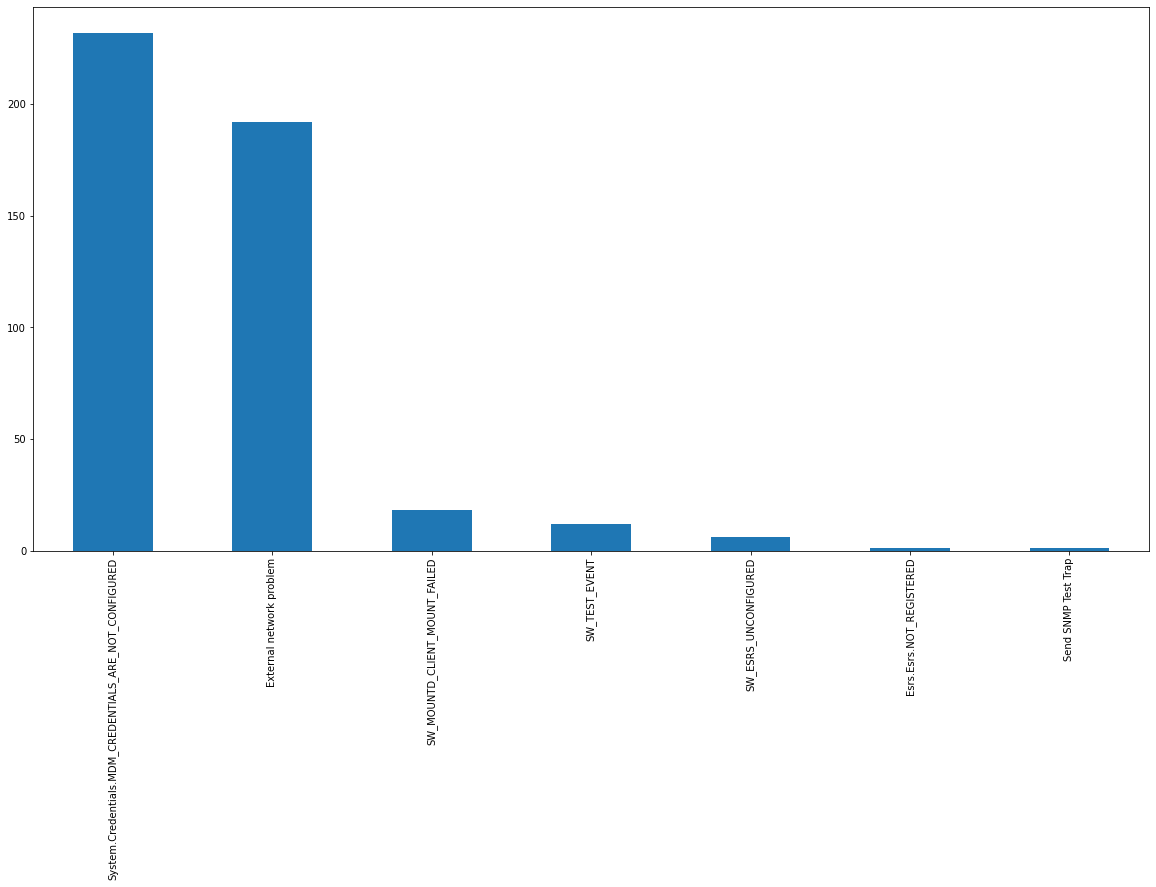

In [44]:
s.plot(kind='bar', figsize=(20,10))

In [37]:
# pandas.set_option("display.max_rows", None)
reports = []
read_events = idracdata.get_data_from_idrac_generator_bymetric_id(from_stream_cut=stream_start,
                                                                  to_stream_cut=stream_end')
for _report in read_events:
    reports.append(_report)
    


SyntaxError: EOL while scanning string literal (<ipython-input-37-7f5c36f560bc>, line 4)

In [ ]:
display(pandas.DataFrame.from_dict(reports, orient='columns').tail())

# Re-Arrange the data(timstap ->ds ; measurement -> y)

In [7]:
df = pandas.DataFrame.from_dict(reports, orient='columns')
df['Timestamp'] = pandas.to_datetime(df['Timestamp'],
                               format="%Y-%m-%dT%H:%M:%S.%fZ")
df.rename(columns = {'Timestamp':'ds'}, inplace = True)
df.rename(columns = {'avg':'y'}, inplace = True)
del df['RemoteAddr']
del df['Id']
del df['MetricId']


In [8]:
df.head()

,ds,y
0,2020-04-28 16:32:12.665,21.333333
1,2020-04-28 16:32:56.157,15.916667
2,2020-04-28 16:33:01.165,17.083333
3,2020-04-28 16:33:02.196,23.500000
4,2020-04-28 16:32:40.987,18.166667


## We fit the model by instantiating a new Prophet object.

In [9]:
m = Prophet(weekly_seasonality=True, daily_seasonality=True)
m.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


## Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made.

In [8]:
future = m.make_future_dataframe(periods=7)
future.tail()

,ds
61776,2020-04-30 18:01:18.940
61777,2020-05-01 18:01:18.940
61778,2020-05-02 18:01:18.940
61779,2020-05-03 18:01:18.940
61780,2020-05-04 18:01:18.940


# Build the Prediction
- The predict method will assign each row in future a predicted value which it names yhat.
- The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [9]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
61776,2020-04-30 18:01:18.940,28.756242,5.878699,53.432568
61777,2020-05-01 18:01:18.940,51.373909,16.203135,89.640780
61778,2020-05-02 18:01:18.940,60.949843,11.305608,113.960074
61779,2020-05-03 18:01:18.940,71.279435,8.460449,143.833167
61780,2020-05-04 18:01:18.940,76.217871,-3.768084,163.064627


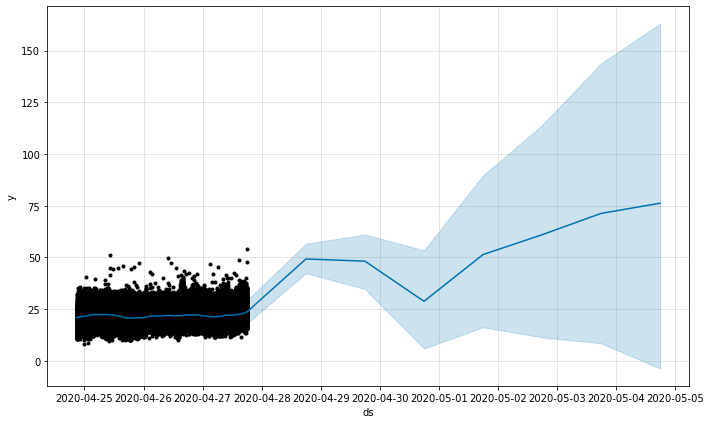

In [10]:
fig1 = m.plot(forecast)

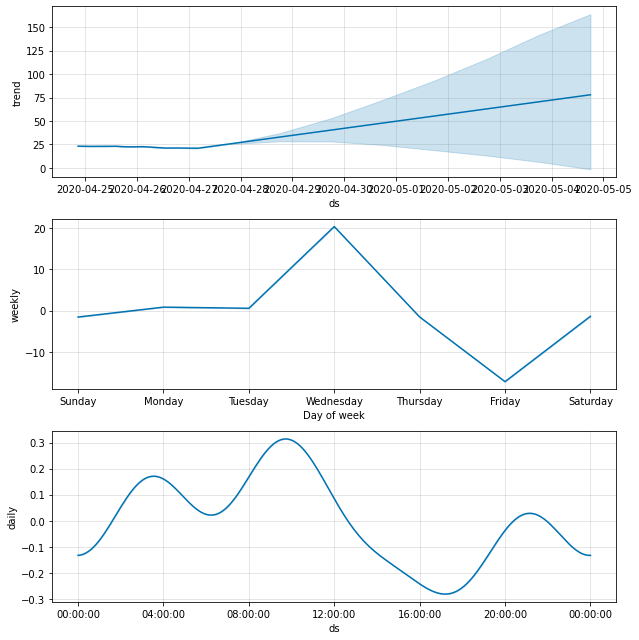

In [11]:
fig2 = m.plot_components(forecast)